In [129]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import corvinus_tardis_data as ctd
import seaborn as sns
import matplotlib.pyplot as plt
# this is a special fix for tardis_dev not liking running from a notebook. it prefers running as a script


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# instead of using the notebook cell, execute in subshell (because asyncio)
! python -m corvinus_tardis_data
! ls -l datasets

Let's read the dataset and organize the columns

In [181]:
options = pd.read_csv('datasets/binance-european-options_trades_2025-05-01_OPTIONS.csv.gz')
options['timestamp'] = pd.to_datetime(options['timestamp'], unit='us')
options['timestamp'] = pd.to_datetime(options['timestamp'], unit='us')

options = options.groupby(['exchange','symbol','timestamp','side']).price.mean()
options = options.reset_index()

options['base'] = options.symbol.str.split('-').str[0]
options['expiration'] = options.symbol.str.split('-').str[1]
options['strike'] = options.symbol.str.split('-').str[2].astype(float)
options['pc'] = options.symbol.str.split('-').str[3]

options


,exchange,symbol,timestamp,side,price,base,expiration,strike,pc
0,binance-european-options,BNB-250501-550-C,2025-05-01 07:21:09.017,sell,50.35,BNB,250501,550.00,C
1,binance-european-options,BNB-250501-550-P,2025-05-01 02:21:37.669,sell,0.40,BNB,250501,550.00,P
2,binance-european-options,BNB-250501-550-P,2025-05-01 04:53:41.983,sell,0.30,BNB,250501,550.00,P
3,binance-european-options,BNB-250501-570-P,2025-05-01 01:05:27.878,sell,0.10,BNB,250501,570.00,P
4,binance-european-options,BNB-250501-580-P,2025-05-01 02:22:40.861,sell,0.10,BNB,250501,580.00,P
...,...,...,...,...,...,...,...,...,...
12335,binance-european-options,XRP-250509-2.5-C,2025-05-01 14:35:33.042,sell,2.09,XRP,250509,2.50,C
12336,binance-european-options,XRP-250509-2.5-C,2025-05-01 14:46:32.765,sell,2.15,XRP,250509,2.50,C
12337,binance-european-options,XRP-250509-2.55-C,2025-05-01 17:54:17.077,buy,2.39,XRP,250509,2.55,C
12338,binance-european-options,XRP-250509-2.7-C,2025-05-01 19:45:25.796,buy,1.16,XRP,250509,2.70,C


Take a particular symbol, and see when it traded

,index,price,num_trades,event
0,2025-05-01 00:00:00.726,4.2,1,True
1,2025-05-01 00:05:00.726,NaN,1,False
2,2025-05-01 00:10:00.726,3.6,7,True
3,2025-05-01 00:15:00.726,NaN,7,False
4,2025-05-01 00:20:00.726,3.6,8,True


,exchange,symbol,timestamp,side,price,base,expiration,strike,pc,traded,num_trades
6447,binance-european-options,ETH-250501-1775-P,2025-05-01 00:00:00.726,buy,4.2,ETH,250501,1775.0,P,1,1
6448,binance-european-options,ETH-250501-1775-P,2025-05-01 00:05:31.187,sell,3.8,ETH,250501,1775.0,P,1,2
6449,binance-european-options,ETH-250501-1775-P,2025-05-01 00:05:50.158,buy,4.0,ETH,250501,1775.0,P,1,3
6450,binance-european-options,ETH-250501-1775-P,2025-05-01 00:05:57.368,sell,3.8,ETH,250501,1775.0,P,1,4
6451,binance-european-options,ETH-250501-1775-P,2025-05-01 00:06:07.999,sell,3.8,ETH,250501,1775.0,P,1,5


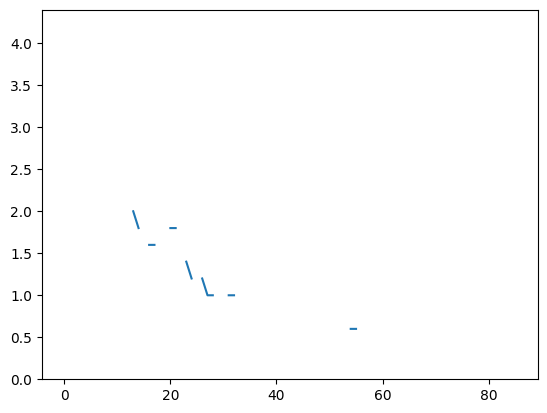

In [211]:
sample = options.loc[options.symbol=='ETH-250501-1775-P'].copy()
mint, maxt = min(sample.timestamp), max(sample.timestamp)
time_range = pd.date_range(mint, maxt, freq="5 min")

sample['traded'] = 1
sample['num_trades'] = sample.traded.cumsum()

on_grid = sample.set_index('timestamp').reindex(time_range, method='ffill')[['price','num_trades']].reset_index()
on_grid['event'] = on_grid.num_trades != on_grid.num_trades.shift()
on_grid.loc[~on_grid.event, 'price'] = np.nan

on_grid.price.plot()
display(on_grid.head())
display(sample.head())

Redo the same but now put the procedure into a function

<Axes: xlabel='timestamp'>

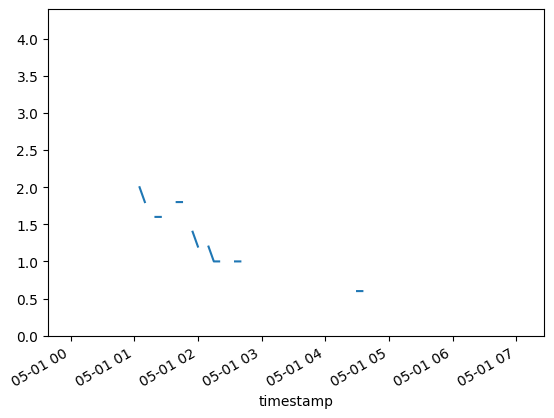

In [232]:
sample = options.loc[options.symbol=='ETH-250501-1775-P'].copy()
mint, maxt = min(sample.timestamp), max(sample.timestamp)
time_range = pd.date_range(mint, maxt, freq="5 min").rename('timestamp')

def one_symbol(g):
    g = g.copy()
    g['traded'] = 1
    g['num_trades'] = g.traded.cumsum()
    on_grid = g.set_index('timestamp').reindex(time_range, method='ffill')[['price','num_trades']].reset_index()
    g['event'] = g.num_trades!= g.num_trades.shift()
    on_grid['event'] = on_grid.num_trades != on_grid.num_trades.shift()
    on_grid.loc[~on_grid.event, 'price'] = np.nan
    return on_grid[['timestamp','price']]

one_symbol(sample).set_index('timestamp').price.plot()


Now do all of this for each of the symbols in the file

timestamp  price
symbol                                            
BNB-250501-550-C 0  2025-05-01 00:00:00.726    NaN
                 1  2025-05-01 00:05:00.726    NaN
                 2  2025-05-01 00:10:00.726    NaN
                 3  2025-05-01 00:15:00.726    NaN
                 4  2025-05-01 00:20:00.726    NaN
...                                     ...    ...
XRP-250509-2.7-C 81 2025-05-01 06:45:00.726    NaN
                 82 2025-05-01 06:50:00.726    NaN
                 83 2025-05-01 06:55:00.726    NaN
                 84 2025-05-01 07:00:00.726    NaN
                 85 2025-05-01 07:05:00.726    NaN

[63898 rows x 2 columns]

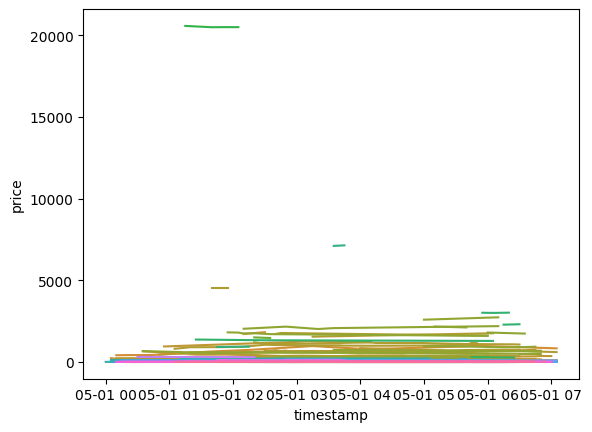

In [222]:


sample = options.copy()
#display(sample)
#display(sample.groupby('symbol')[['timestamp','price']].first())
on_grid = sample.groupby('symbol')[['timestamp','price']].apply(one_symbol)

sns.lineplot(data=on_grid.reset_index(), x='timestamp', hue='symbol',y='price')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.legend().remove()
on_grid

<Axes: xlabel='timestamp'>

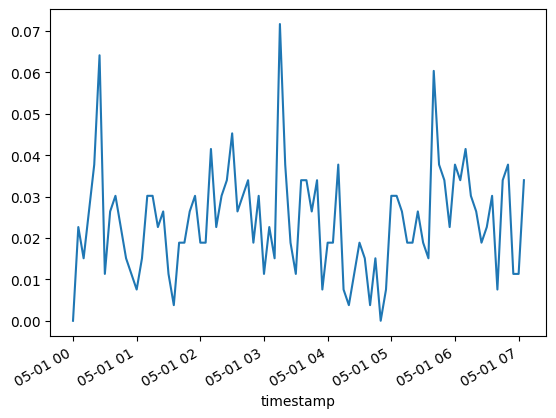

In [249]:

sample = options.loc[options.base == 'BTC']
#display(sample)
on_grid = sample.groupby('symbol')[['timestamp','price']].apply(one_symbol).reset_index()
#display(on_grid.head())
df = on_grid.set_index(['timestamp','symbol']).unstack('timestamp').price
#display(df)
toplot = (~df.isna()).astype(float).describe().T
#display(toplot)
toplot['mean'].plot()